# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%matplotlib inline
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

## Get the data

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

In [3]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [4]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)
label_feature_name = 'is_somatic'

In [5]:
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact = impact[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns = categorical_features_names, sparse = True)

# reduced dataset
impact = pd.concat([impact[~impact.is_somatic],
                    impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

X = impact.drop(label_feature_name, axis = 1)
y = impact[label_feature_name]

In [6]:
print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)
# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Dummy

### Uniform

Generates predictions uniformly at random → expected accuracy: 0.5 | expected AUC: 0.5.

In [8]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy = 'uniform', random_state = 1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.50 ± 0.01
▴ Mean ROC AUC : 0.50 ± 0.00


In [9]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.09s | 0.00s]
  → accuracy: [0.51 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.06s | 0.00s]
  → accuracy: [0.50 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]


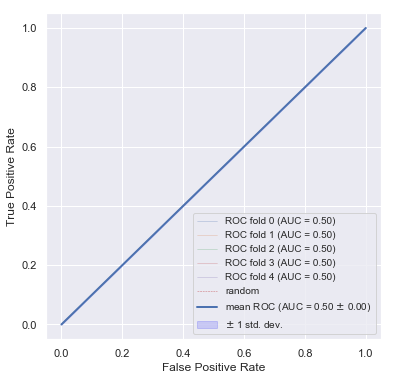

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [11]:
model = DummyClassifier(strategy = 'most_frequent', random_state = 1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.74 ± 0.00
▴ Mean ROC AUC : 0.50 ± 0.00


In [12]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]


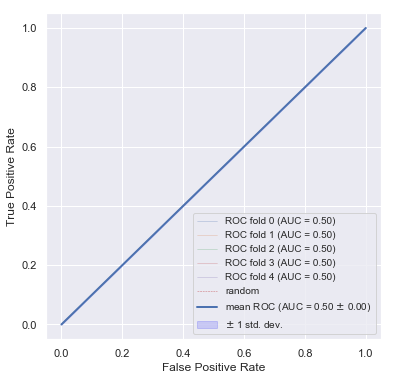

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

## Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.81 ± 0.01
▴ Mean ROC AUC : 0.83 ± 0.01


In [15]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.07s | 0.01s]
  → accuracy: [0.81 | 0.81]
  → ROC AUC : [0.83 | 0.83]
Fold 2: [0.07s | 0.01s]
  → accuracy: [0.81 | 0.81]
  → ROC AUC : [0.83 | 0.83]
Fold 3: [0.07s | 0.01s]
  → accuracy: [0.82 | 0.81]
  → ROC AUC : [0.83 | 0.83]
Fold 4: [0.07s | 0.01s]
  → accuracy: [0.81 | 0.81]
  → ROC AUC : [0.84 | 0.84]
Fold 5: [0.08s | 0.01s]
  → accuracy: [0.81 | 0.81]
  → ROC AUC : [0.83 | 0.84]


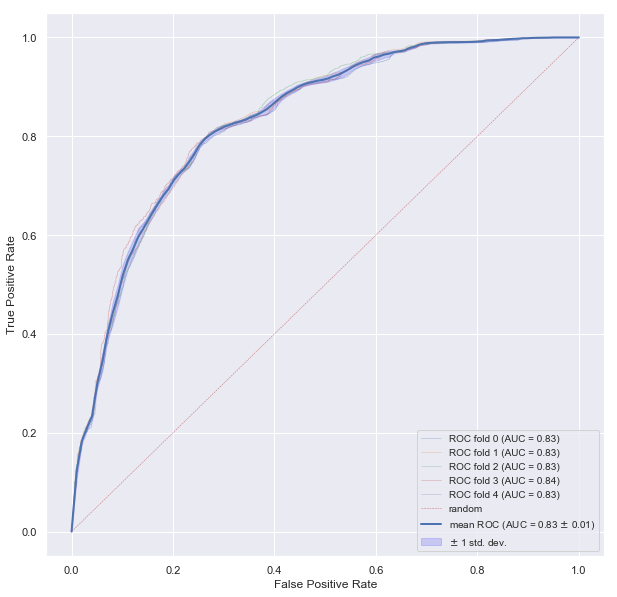

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(metrics, ax)

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(random_state = 1, cv = inner_cv_strategy, max_iter = 2000, n_jobs = -1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.86 ± 0.01
▴ Mean ROC AUC : 0.88 ± 0.01


In [18]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [6.90s | 0.01s]
  → accuracy: [0.86 | 0.86]
  → ROC AUC : [0.88 | 0.88]
Fold 2: [9.59s | 0.01s]
  → accuracy: [0.86 | 0.86]
  → ROC AUC : [0.88 | 0.88]
Fold 3: [12.49s | 0.01s]
  → accuracy: [0.87 | 0.87]
  → ROC AUC : [0.89 | 0.88]
Fold 4: [5.83s | 0.01s]
  → accuracy: [0.86 | 0.86]
  → ROC AUC : [0.88 | 0.88]
Fold 5: [9.80s | 0.01s]
  → accuracy: [0.86 | 0.86]
  → ROC AUC : [0.88 | 0.89]


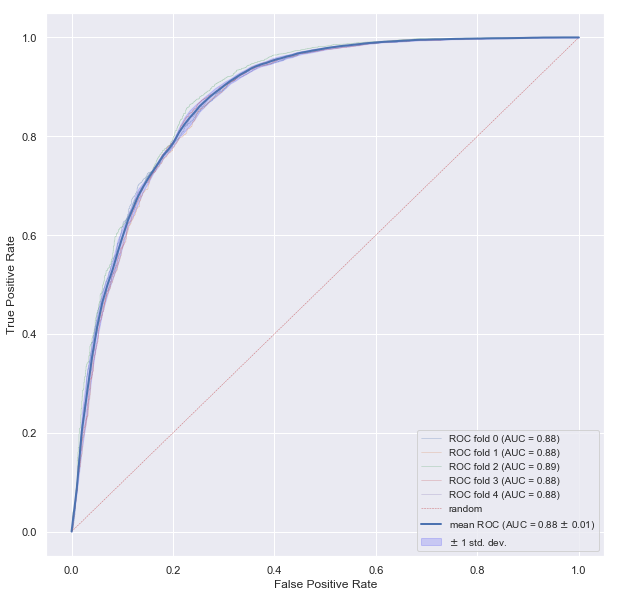

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(metrics, ax)

## K Nearest Neighbors

In [47]:
job = Selene_Job('KNN', 'guilminp', load_from_id = True)

<span style='color:green'>Job < KNN >: </span>✅ job found and reloaded<br>

In [51]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ data loaded<br>

In [52]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# choose a model
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)

parameters_grid = [
    {'classify__n_neighbors': [2, 10, 20, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
]

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model = GridSearchCV(pipe, parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search = True, n_jobs = 5)


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Overwriting ssh_remote_jobs/job_KNN/script.py


In [53]:
job.run(n_jobs = 5, short_job = False)

➞ scp ssh_remote_jobs/job_KNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100%  137KB   4.9MB/s   00:00    
metrics.pkl                                   100%   80MB  16.2MB/s   00:04    
script.py                                     100% 1364   166.5KB/s   00:00    
X.pkl                                         100% 5266KB  15.2MB/s   00:00    
y.pkl                                         100%  452KB  10.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN
Job <28293662> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5]" "python script.py"


<span style='color:green'>Job < KNN >: </span>✅ submitted<br>

In [48]:
job.get_results()

<span style='color:green'>Job < KNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN to ssh_remote_jobs/job_KNN
metrics.pkl                                   100%   80MB   8.7MB/s   00:09    
job_output.txt                                100%  137KB   2.2MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy: 0.88 ± 0.00
▴ Mean ROC AUC : 0.91 ± 0.00


In [49]:
print_fold_metrics(job.metrics, grid_search = True)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [1104.53s | 17.78s]
  → accuracy: [0.88 | 1.00]
  → ROC AUC : [0.91 | 1.00]
  → Best parameters : {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
    0.85 ± 0.01 for {'classify__n_neighbors': 2, 'classify__weights': 'uniform'}
    0.85 ± 0.01 for {'classify__n_neighbors': 2, 'classify__weights': 'distance'}
    0.89 ± 0.01 for {'classify__n_neighbors': 10, 'classify__weights': 'uniform'}
    0.90 ± 0.01 for {'classify__n_neighbors': 10, 'classify__weights': 'distance'}
    0.90 ± 0.01 for {'classify__n_neighbors': 20, 'classify__weights': 'uniform'}
    0.91 ± 0.01 for {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
    0.89 ± 0.01 for {'classify__n_neighbors': 100, 'classify__weights': 'uniform'}
    0.90 ± 0.00 for {'classify__n_neighbors': 100, 'classify__weights': 'distance'}
Fold 2: [1328.67s | 42.19s]
  → accuracy: [

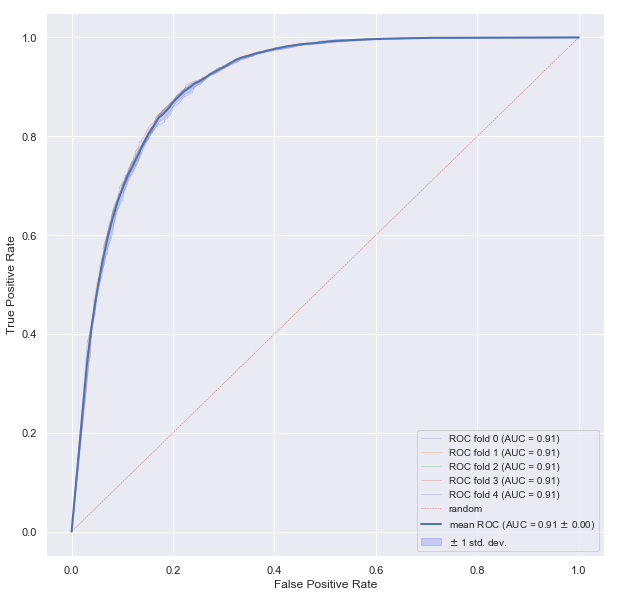

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(job.metrics, ax)

## Random Forest

In [37]:
%run Selene_Job.ipy

In [56]:
job.remove()

➞ rm on local computer ssh_remote_jobs/job_KNN
➞ rm on cluster guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ removed from local computer and cluster<br>

In [57]:
job = Selene_Job('RandomForest', 'guilminp')

<span style='color:red'>Job < RandomForest >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [58]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_RandomForest


<span style='color:green'>Job < RandomForest >: </span>✅ data loaded<br>

In [59]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV

# choose a model
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model = GridSearchCV(RandomForestClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search = True, n_jobs = 5)


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Overwriting ssh_remote_jobs/job_RandomForest/script.py


In [60]:
job.run(n_jobs = 5, short_job = False, memory = 8)

➞ scp ssh_remote_jobs/job_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100% 1015   166.5KB/s   00:00    
X.pkl                                         100% 5266KB   3.9MB/s   00:01    
y.pkl                                         100%  452KB   5.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest
Job <28293688> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "python script.py"


<span style='color:green'>Job < RandomForest >: </span>✅ submitted<br>

In [118]:
job.get_results()

<span style='color:green'>Job < RandomForest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest to ssh_remote_jobs/job_RandomForest
metrics.pkl                                   100% 1681MB   7.4MB/s   03:47    
job_output.txt                                100% 4631     1.1MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy: 0.90 ± 0.00
▴ Mean ROC AUC : 0.94 ± 0.00


In [119]:
print_fold_metrics(job.metrics, grid_search = True)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [389.95s | 4.67s]
  → accuracy: [0.91 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.89 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.90 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.90 ± 0.01 for {'max_depth': 5, 'n_estimators': 1000}
    0.92 ± 0.01 for {'max_depth': 20, 'n_estimators': 10}
    0.93 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
    0.93 ± 0.00 for {'max_depth': 20, 'n_estimators': 1000}
    0.92 ± 0.01 for {'max_depth': 50, 'n_estimators': 10}
    0.93 ± 0.00 for {'max_depth': 50, 'n_estimators': 100}
    0.94 ± 0.01 for {'max_depth': 50, 'n_estimators': 1000}
Fold 2: [368.56s | 10.38s]
  → accuracy: [0.90 | 1.00]
  → ROC AUC : [0.94 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.89 ± 0.01 for {'max_depth': 5, 'n_estimators': 10

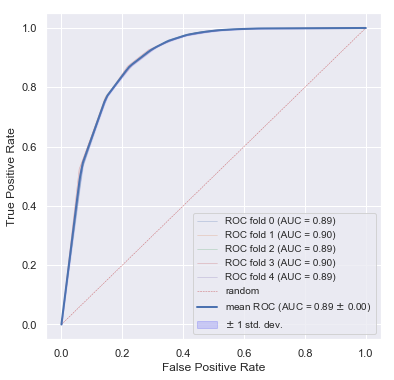

In [97]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(job.metrics, ax)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model = GridSearchCV(RandomForestClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

metrics = run_model(model, X, y, cv_strategy, grid_search = True, n_jobs = 1)

Run model...

In [ ]:
print_mean_metrics(metrics)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 20)
run_model(model_best_RandomForestClassifier, X, y, cv_strategy, n_jobs = 5)

model_best_RandomForestClassifier.fit(X, y)

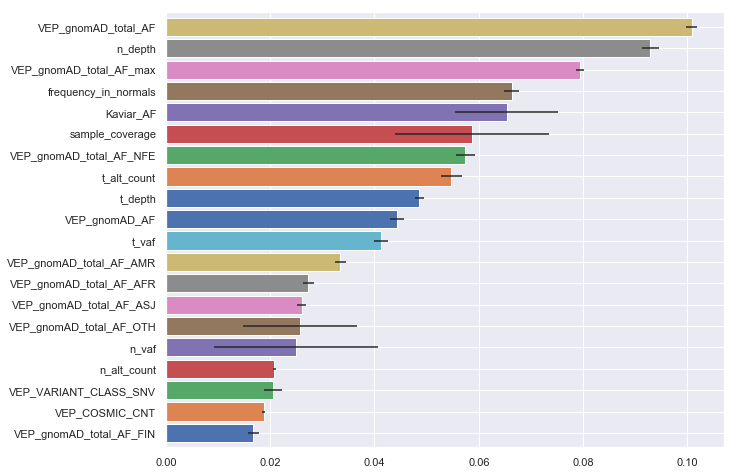

In [116]:
feature_importance = pd.DataFrame({'value': model_best_RandomForestClassifier.feature_importances_.tolist()}, index = X.columns.tolist())
feature_importance.sort_values(by = 'value', axis = 0, inplace = True)

feature_importance['std_dev'] = np.std([tree.feature_importances_ for tree in model_best_RandomForestClassifier.estimators_], axis = 0)

feature_importance = feature_importance.tail(20)

feature_importance.value.plot.barh(figsize = (10, 8), width = 0.85, xerr = feature_importance.std_dev, align = 'center');

## Gradient Boosting

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [34.91s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.88 | 0.90]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.82 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.84 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.88 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 100}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 10}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 100}
Fold 1: [34.75s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.90 | 0.89]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.83 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.85 ± 0.01 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.8

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,34.9126,0.0791869,0.882118,0.880331,0.896267,0.882781,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,34.751,0.0789692,0.882991,0.880147,0.89475,0.895432,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,34.4062,0.0763741,0.883083,0.879596,0.896355,0.880396,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,35.1259,0.0756898,0.884002,0.879596,0.896101,0.886436,"{'learning_rate': 0.1, 'n_estimators': 100}"
4,33.4458,0.0784383,0.882348,0.881801,0.89522,0.889147,"{'learning_rate': 0.1, 'n_estimators': 100}"


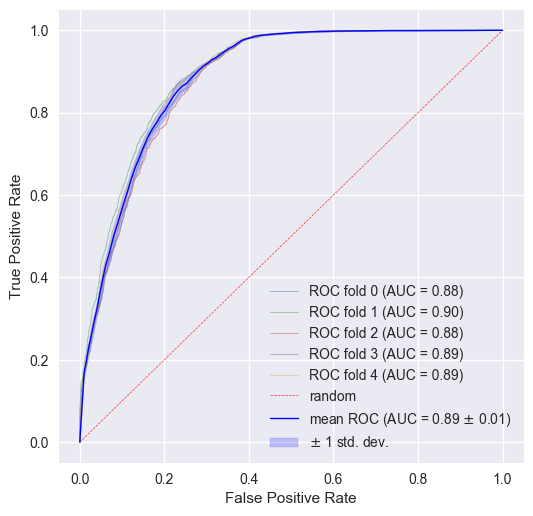

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100]}
]

model_GS_GradientBoostingClassifier = GridSearchCV(GradientBoostingClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_GradientBoostingClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


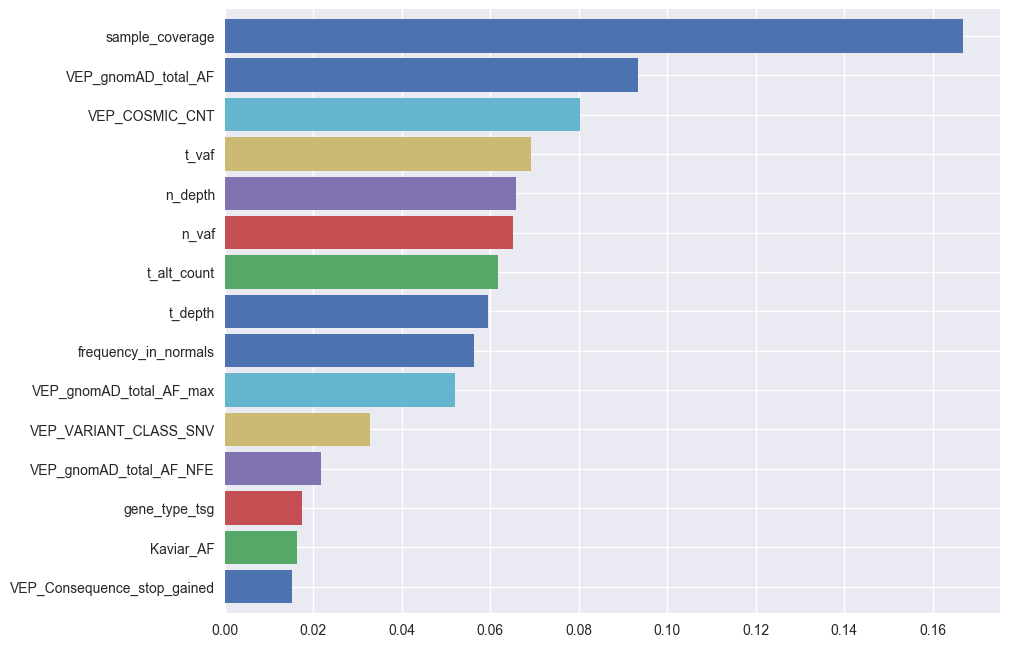

In [30]:
model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state = 1, learning_rate = 0.1, n_estimators = 100)
run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy)

model_best_GradientBoostingClassifier.fit(X, y)

feature_importance = pd.Series(model_best_GradientBoostingClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = False, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting